# Preparing the environment

In [141]:
!pip install cmake gym[atari] scipy

In [142]:
from IPython.display import clear_output
import gym
env = gym.make("Taxi-v3").env
env.render()

# A module of functions that can use multiple environments

In [143]:
class RandomAgent:

    def __init__(self, env):
        self.env = env

    def get_action(self, state) -> int:
        """
        No input arguments to this function.
        The agent does not consider the state of the environment when deciding
        what to do next.
        """
        return self.env.action_space.sample()

import numpy as np

        
import numpy as np
from pdb import set_trace as stop


class QAgent:

    def __init__(self, env, alpha, gamma):
        self.env = env

        # table with q-values: n_states * n_actions
        self.q_table = np.zeros([env.observation_space.n, env.action_space.n])

        # hyper-parameters
        self.alpha = alpha
        self.gamma = gamma

    def get_action(self, state):
        """"""
        # stop()
        return np.argmax(self.q_table[state])

    def update_parameters(self, state, action, reward, next_state):
        """"""
        old_value = self.q_table[state, action]
        next_max = np.max(self.q_table[next_state])

        new_value = (1 - self.alpha) * old_value + self.alpha * (reward + self.gamma * next_max)
        self.q_table[state, action] = new_value

    def reset(self):
        """
        Sets q-values to zeros, which essentially means the agent does not know
        anything
        """
        self.q_table = np.zeros([self.env.observation_space.n, self.env.action_space.n])

        
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print(f"Timestep: {i + 1} of {len(frames)}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.01)        
        
        
from typing import Tuple, List, Any
import random
from pdb import set_trace as stop

import numpy as np
from tqdm import tqdm


def train(
    agent,
    env,
    n_episodes: int,
    epsilon: float
) -> Tuple[Any, List, List]:
    """
    Trains and agent and returns 3 things:
    - agent object
    - timesteps_per_episode
    - penalties_per_episode
    """
    # For plotting metrics
    timesteps_per_episode = []
    penalties_per_episode = []

    for i in tqdm(range(0, n_episodes)):

        state = env.reset()

        epochs, penalties, reward, = 0, 0, 0
        done = False

        while not done:

            if random.uniform(0, 1) < epsilon:
                # Explore action space
                action = env.action_space.sample()
            else:
                # Exploit learned values
                action = agent.get_action(state)

            next_state, reward, done, info = env.step(action)

            agent.update_parameters(state, action, reward, next_state)

            if reward == -10:
                penalties += 1

            state = next_state
            epochs += 1

        timesteps_per_episode.append(epochs)
        penalties_per_episode.append(penalties)

    return agent, timesteps_per_episode, penalties_per_episode


def evaluate(
    agent,
    env,
    n_episodes: int,
    epsilon: float,
    initial_state: int = None
) -> Tuple[List, List]:
    """
    Tests agent performance in random `n_episodes`.
    It returns:
    - timesteps_per_episode
    - penalties_per_episode
    """
    # For plotting metrics
    timesteps_per_episode = []
    penalties_per_episode = []
    frames_per_episode = []

    for i in tqdm(range(0, n_episodes)):

        if initial_state:
            # init the environment at 'initial_state'
            state = initial_state
            env.s = initial_state
        else:
            # random starting state
            state = env.reset()

        epochs, penalties, reward, = 0, 0, 0
        frames = []
        done = False

        while not done:

            if random.uniform(0, 1) < epsilon:
                # Explore action space
                action = env.action_space.sample()
            else:
                # Exploit learned values
                action = agent.get_action(state)

            next_state, reward, done, info = env.step(action)

            frames.append({
                'frame': env.render(mode='ansi'),
                'state': state,
                'action': action,
                'reward': reward
            })

            if reward == -10:
                penalties += 1

            state = next_state
            epochs += 1

        timesteps_per_episode.append(epochs)
        penalties_per_episode.append(penalties)
        frames_per_episode.append(frames)

    return timesteps_per_episode, penalties_per_episode, frames_per_episode


def train_many_runs(
    agent,
    env,
    n_episodes: int,
    epsilon: float,
    n_runs: int,
) -> Tuple[List, List]:
    """
    Calls 'train' many times, stores results and averages them out.
    """
    timesteps = np.zeros(shape=(n_runs, n_episodes))
    penalties = np.zeros(shape=(n_runs, n_episodes))

    for i in range(0, n_runs):

        agent.reset()

        _, timesteps[i, :], penalties[i, :] = train(
            agent, env, n_episodes, epsilon
        )
    timesteps = np.mean(timesteps, axis=0).tolist()
    penalties = np.mean(penalties, axis=0).tolist()

    return timesteps, penalties

# Evaluation of the agent starting from a definite state

In [144]:
alpha = 0.1
gamma = 0.6

agent = QAgent(env, alpha, gamma)

In [145]:
import random
from tqdm import tqdm

# exploration vs exploitation prob
epsilon = 0.1

n_episodes = 10000

# For plotting metrics
timesteps_per_episode = []
penalties_per_episode = []


for i in tqdm(range(0, n_episodes)):
    
    state = env.reset()

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        
        if random.uniform(0, 1) < epsilon:
            # Explore action space
            action = env.action_space.sample()
        else:
            # Exploit learned values
            action = agent.get_action(state)
        
        next_state, reward, done, info = env.step(action) 
        
        agent.update_parameters(state, action, reward, next_state)
        
        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
        
    timesteps_per_episode.append(epochs)
    penalties_per_episode.append(penalties)


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1356.15it/s]


In [146]:
# set initial state of the environment
state = 123
env.s = state

epochs = 0
penalties = 0
reward = 0

# store frames to latter plot them
frames = []

done = False

while not done:
    
    action = agent.get_action(state)
    
    next_state, reward, done, info = env.step(action)
    agent.update_parameters(state, action, reward, next_state)

    if reward == -10:
        penalties += 1
    
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    state = next_state

    epochs += 1
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 27
Penalties incurred: 0


# Evaluation of the trained agent on 100 episodes

In [147]:
import random
from tqdm import tqdm

# exploration vs exploitation prob
epsilon = 0.05

n_episodes = 100

# For plotting metrics
timesteps_per_episode = []
penalties_per_episode = []


for i in tqdm(range(0, n_episodes)):
    
    state = env.reset()      
    
    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        
        if random.uniform(0, 1) < epsilon:
            # Explore action space
            action = env.action_space.sample()
        else:
            # Exploit learned values
            action = agent.get_action(state)
        
        next_state, reward, done, info = env.step(action)
        
        agent.update_parameters(state, action, reward, next_state)
                      
        if reward == -10:
            penalties += 1

        state = next_state
        epochs += 1
            
    timesteps_per_episode.append(epochs)
    penalties_per_episode.append(penalties)

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1856.86it/s]


In [148]:
print(f'Avg steps to complete ride: {np.array(timesteps_per_episode).mean()}')
print(f'Avg penalties to complete ride: {np.array(penalties_per_episode).mean()}')

Avg steps to complete ride: 13.77
Avg penalties to complete ride: 0.14


# Tuning and analyzing hyperparameters (alpha, gamma and epsilon)

In [149]:
alphas = [0.01, 0.1, 1]
gammas = [0.1, 0.6, 0.9]

import pandas as pd

# exploration vs exploitation prob
# let's start with a constant probability of 10%.
epsilon = 0.1
n_episodes = 1000

results = pd.DataFrame()
for alpha in alphas:
    for gamma in gammas:
        
        print(f'alpha: {alpha}, gamma: {gamma}')
        agent = QAgent(env, alpha, gamma)
        
        _, timesteps, penalties = train(agent,
                                        env,
                                        n_episodes,
                                        epsilon)
        
        # collect timesteps and penalties for this pair
        # of hyper-parameters (alpha, gamma)
        results_ = pd.DataFrame()
        results_['timesteps'] = timesteps
        results_['penalties'] = penalties
        results_['alpha'] = alpha
        results_['gamma'] = gamma
        results = pd.concat([results, results_])

# index -> episode
results = results.reset_index().rename(
    columns={'index': 'episode'})

# add column with the 2 hyper-parameters
results['hyperparameters'] = [
    f'alpha={a}, gamma={g}'
    for (a, g) in zip(results['alpha'], results['gamma'])
]

alpha: 0.01, gamma: 0.1


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 48.27it/s]


alpha: 0.01, gamma: 0.6


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 87.33it/s]


alpha: 0.01, gamma: 0.9


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:09<00:00, 106.98it/s]


alpha: 0.1, gamma: 0.1


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 145.14it/s]


alpha: 0.1, gamma: 0.6


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 333.96it/s]


alpha: 0.1, gamma: 0.9


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 415.20it/s]


alpha: 1, gamma: 0.1


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1227.95it/s]


alpha: 1, gamma: 0.6


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1289.36it/s]


alpha: 1, gamma: 0.9


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1238.18it/s]


# Plot analysis (1)

C:\Users\Shahin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='episode', ylabel='timesteps'>

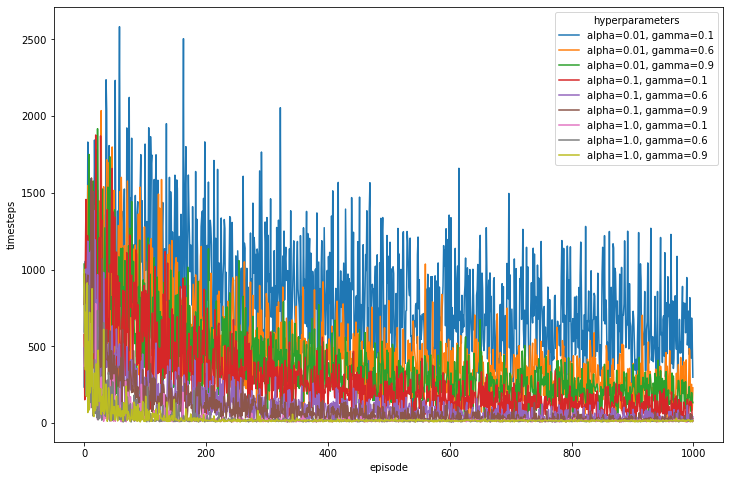

In [150]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.lineplot('episode', 'timesteps',
             hue='hyperparameters', data=results)

## Averaging over several runs

In [151]:
alphas = [0.1, 1]
gammas = [0.1, 0.6, 0.9]

epsilon = 0.1
n_episodes = 1000
n_runs = 10

results = pd.DataFrame()
for alpha in alphas:
    for gamma in gammas:
        
        print(f'alpha: {alpha}, gamma: {gamma}')
        agent = QAgent(env, alpha, gamma)
        
        timesteps, penalties = train_many_runs(agent,
                                               env,
                                               n_episodes,
                                               epsilon,
                                               n_runs)
        
        # collect timesteps and penalties for this pair of
        # hyper-parameters (alpha, gamma)
        results_ = pd.DataFrame()
        results_['timesteps'] = timesteps
        results_['penalties'] = penalties
        results_['alpha'] = alpha
        results_['gamma'] = gamma
        results = pd.concat([results, results_])

# index -> episode
results = results.reset_index().rename(
    columns={'index': 'episode'})

# add column with the 2 hyper-parameters
results['hyperparameters'] = [
    f'alpha={a}, gamma={g}'
    for (a, g) in zip(results['alpha'], results['gamma'])
]

alpha: 0.1, gamma: 0.1


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 146.93it/s]


alpha: 0.1, gamma: 0.6


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 337.25it/s]


alpha: 0.1, gamma: 0.9


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 419.46it/s]


alpha: 1, gamma: 0.1


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1236.72it/s]


alpha: 1, gamma: 0.6


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1254.05it/s]


alpha: 1, gamma: 0.9


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1209.06it/s]


# Implementing a grid search to discover the best hyperparameters (1)

In [152]:
results

,episode,timesteps,penalties,alpha,gamma,hyperparameters
0,0,812.6,129.7,0.1,0.1,"alpha=0.1, gamma=0.1"
1,1,621.8,86.8,0.1,0.1,"alpha=0.1, gamma=0.1"
2,2,858.7,100.0,0.1,0.1,"alpha=0.1, gamma=0.1"
3,3,751.9,94.9,0.1,0.1,"alpha=0.1, gamma=0.1"
4,4,891.0,70.6,0.1,0.1,"alpha=0.1, gamma=0.1"
...,...,...,...,...,...,...
5995,995,14.9,0.4,1.0,0.9,"alpha=1.0, gamma=0.9"
5996,996,16.0,0.4,1.0,0.9,"alpha=1.0, gamma=0.9"
5997,997,16.2,0.5,1.0,0.9,"alpha=1.0, gamma=0.9"
5998,998,16.1,0.3,1.0,0.9,"alpha=1.0, gamma=0.9"


In [153]:
X = results.iloc[:, :4].values
Y = results.iloc[:, 4].values.reshape(-1,1)

In [154]:
print(np.shape(X))
print(np.shape(Y))

(6000, 4)
(6000, 1)


In [155]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2, random_state = 2022)

In [156]:
!pip3 install xgboost
from xgboost import XGBRegressor
xgb_model = XGBRegressor(random_state = 2022)

In [157]:
# make a dictionary of hyperparameter values to search
search_space = {
    "n_estimators" : [100, 200, 300, 400, 500],
    "max_depth" : [3, 6, 9],
    "gamma" : [0.01, 0.1],
    "learning_rate" : [0.001, 0.01, 0.1, 1]
}

In [158]:
from sklearn.model_selection import GridSearchCV
# make a GridSearchCV object
GS = GridSearchCV(estimator = xgb_model, 
                  param_grid = search_space,
                  scoring = ["r2", "neg_root_mean_squared_error"], # sklearn.metrics.SCORES.keys()
                  refit = "r2",
                  cv = 5,
                  verbose = 4)

In [159]:
GS.fit(X_train, Y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-0.321) r2: (test=0.027) total time=   0.1s
[CV 2/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-0.323) r2: (test=0.047) total time=   0.1s
[CV 3/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-0.325) r2: (test=0.054) total time=   0.1s
[CV 4/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-0.319) r2: (test=0.037) total time=   0.1s
[CV 5/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-0.323) r2: (test=0.048) total time=   0.1s
[CV 1/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=200; neg_root_mean_squared_error: (test=-0.313) r2: (test=0.074) total time=   0.3s
[

[CV 4/5] END gamma=0.01, learning_rate=0.001, max_depth=9, n_estimators=100; neg_root_mean_squared_error: (test=-0.315) r2: (test=0.060) total time=   0.4s
[CV 5/5] END gamma=0.01, learning_rate=0.001, max_depth=9, n_estimators=100; neg_root_mean_squared_error: (test=-0.318) r2: (test=0.076) total time=   0.4s
[CV 1/5] END gamma=0.01, learning_rate=0.001, max_depth=9, n_estimators=200; neg_root_mean_squared_error: (test=-0.306) r2: (test=0.117) total time=   0.8s
[CV 2/5] END gamma=0.01, learning_rate=0.001, max_depth=9, n_estimators=200; neg_root_mean_squared_error: (test=-0.306) r2: (test=0.147) total time=   0.8s
[CV 3/5] END gamma=0.01, learning_rate=0.001, max_depth=9, n_estimators=200; neg_root_mean_squared_error: (test=-0.309) r2: (test=0.141) total time=   0.8s
[CV 4/5] END gamma=0.01, learning_rate=0.001, max_depth=9, n_estimators=200; neg_root_mean_squared_error: (test=-0.304) r2: (test=0.125) total time=   0.8s
[CV 5/5] END gamma=0.01, learning_rate=0.001, max_depth=9, n_est

[CV 2/5] END gamma=0.01, learning_rate=0.01, max_depth=6, n_estimators=200; neg_root_mean_squared_error: (test=-0.243) r2: (test=0.462) total time=   0.5s
[CV 3/5] END gamma=0.01, learning_rate=0.01, max_depth=6, n_estimators=200; neg_root_mean_squared_error: (test=-0.253) r2: (test=0.423) total time=   0.5s
[CV 4/5] END gamma=0.01, learning_rate=0.01, max_depth=6, n_estimators=200; neg_root_mean_squared_error: (test=-0.247) r2: (test=0.423) total time=   0.5s
[CV 5/5] END gamma=0.01, learning_rate=0.01, max_depth=6, n_estimators=200; neg_root_mean_squared_error: (test=-0.252) r2: (test=0.422) total time=   0.5s
[CV 1/5] END gamma=0.01, learning_rate=0.01, max_depth=6, n_estimators=300; neg_root_mean_squared_error: (test=-0.251) r2: (test=0.408) total time=   0.8s
[CV 2/5] END gamma=0.01, learning_rate=0.01, max_depth=6, n_estimators=300; neg_root_mean_squared_error: (test=-0.241) r2: (test=0.471) total time=   0.8s
[CV 3/5] END gamma=0.01, learning_rate=0.01, max_depth=6, n_estimators

[CV 5/5] END gamma=0.01, learning_rate=0.1, max_depth=3, n_estimators=200; neg_root_mean_squared_error: (test=-0.254) r2: (test=0.411) total time=   0.3s
[CV 1/5] END gamma=0.01, learning_rate=0.1, max_depth=3, n_estimators=300; neg_root_mean_squared_error: (test=-0.253) r2: (test=0.397) total time=   0.4s
[CV 2/5] END gamma=0.01, learning_rate=0.1, max_depth=3, n_estimators=300; neg_root_mean_squared_error: (test=-0.247) r2: (test=0.445) total time=   0.4s
[CV 3/5] END gamma=0.01, learning_rate=0.1, max_depth=3, n_estimators=300; neg_root_mean_squared_error: (test=-0.258) r2: (test=0.400) total time=   0.4s
[CV 4/5] END gamma=0.01, learning_rate=0.1, max_depth=3, n_estimators=300; neg_root_mean_squared_error: (test=-0.254) r2: (test=0.388) total time=   0.4s
[CV 5/5] END gamma=0.01, learning_rate=0.1, max_depth=3, n_estimators=300; neg_root_mean_squared_error: (test=-0.257) r2: (test=0.398) total time=   0.4s
[CV 1/5] END gamma=0.01, learning_rate=0.1, max_depth=3, n_estimators=400; n

[CV 4/5] END gamma=0.01, learning_rate=0.1, max_depth=9, n_estimators=300; neg_root_mean_squared_error: (test=-0.273) r2: (test=0.294) total time=   0.9s
[CV 5/5] END gamma=0.01, learning_rate=0.1, max_depth=9, n_estimators=300; neg_root_mean_squared_error: (test=-0.274) r2: (test=0.315) total time=   0.9s
[CV 1/5] END gamma=0.01, learning_rate=0.1, max_depth=9, n_estimators=400; neg_root_mean_squared_error: (test=-0.269) r2: (test=0.318) total time=   1.2s
[CV 2/5] END gamma=0.01, learning_rate=0.1, max_depth=9, n_estimators=400; neg_root_mean_squared_error: (test=-0.265) r2: (test=0.361) total time=   1.2s
[CV 3/5] END gamma=0.01, learning_rate=0.1, max_depth=9, n_estimators=400; neg_root_mean_squared_error: (test=-0.282) r2: (test=0.285) total time=   1.2s
[CV 4/5] END gamma=0.01, learning_rate=0.1, max_depth=9, n_estimators=400; neg_root_mean_squared_error: (test=-0.273) r2: (test=0.294) total time=   1.3s
[CV 5/5] END gamma=0.01, learning_rate=0.1, max_depth=9, n_estimators=400; n

[CV 3/5] END gamma=0.01, learning_rate=1, max_depth=6, n_estimators=400; neg_root_mean_squared_error: (test=-0.350) r2: (test=-0.098) total time=   0.9s
[CV 4/5] END gamma=0.01, learning_rate=1, max_depth=6, n_estimators=400; neg_root_mean_squared_error: (test=-0.325) r2: (test=-0.001) total time=   0.9s
[CV 5/5] END gamma=0.01, learning_rate=1, max_depth=6, n_estimators=400; neg_root_mean_squared_error: (test=-0.350) r2: (test=-0.120) total time=   0.9s
[CV 1/5] END gamma=0.01, learning_rate=1, max_depth=6, n_estimators=500; neg_root_mean_squared_error: (test=-0.328) r2: (test=-0.016) total time=   1.1s
[CV 2/5] END gamma=0.01, learning_rate=1, max_depth=6, n_estimators=500; neg_root_mean_squared_error: (test=-0.326) r2: (test=0.033) total time=   1.2s
[CV 3/5] END gamma=0.01, learning_rate=1, max_depth=6, n_estimators=500; neg_root_mean_squared_error: (test=-0.350) r2: (test=-0.098) total time=   1.1s
[CV 4/5] END gamma=0.01, learning_rate=1, max_depth=6, n_estimators=500; neg_root_m

[CV 2/5] END gamma=0.1, learning_rate=0.001, max_depth=3, n_estimators=500; neg_root_mean_squared_error: (test=-0.297) r2: (test=0.195) total time=   0.8s
[CV 3/5] END gamma=0.1, learning_rate=0.001, max_depth=3, n_estimators=500; neg_root_mean_squared_error: (test=-0.297) r2: (test=0.206) total time=   0.8s
[CV 4/5] END gamma=0.1, learning_rate=0.001, max_depth=3, n_estimators=500; neg_root_mean_squared_error: (test=-0.294) r2: (test=0.181) total time=   0.8s
[CV 5/5] END gamma=0.1, learning_rate=0.001, max_depth=3, n_estimators=500; neg_root_mean_squared_error: (test=-0.298) r2: (test=0.187) total time=   0.8s
[CV 1/5] END gamma=0.1, learning_rate=0.001, max_depth=6, n_estimators=100; neg_root_mean_squared_error: (test=-0.318) r2: (test=0.050) total time=   0.2s
[CV 2/5] END gamma=0.1, learning_rate=0.001, max_depth=6, n_estimators=100; neg_root_mean_squared_error: (test=-0.319) r2: (test=0.074) total time=   0.2s
[CV 3/5] END gamma=0.1, learning_rate=0.001, max_depth=6, n_estimators

[CV 5/5] END gamma=0.1, learning_rate=0.001, max_depth=9, n_estimators=500; neg_root_mean_squared_error: (test=-0.283) r2: (test=0.270) total time=   2.2s
[CV 1/5] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-0.281) r2: (test=0.254) total time=   0.1s
[CV 2/5] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-0.281) r2: (test=0.282) total time=   0.1s
[CV 3/5] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-0.280) r2: (test=0.296) total time=   0.1s
[CV 4/5] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-0.279) r2: (test=0.264) total time=   0.1s
[CV 5/5] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-0.282) r2: (test=0.273) total time=   0.1s
[CV 1/5] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200; 

[CV 4/5] END gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=100; neg_root_mean_squared_error: (test=-0.262) r2: (test=0.352) total time=   0.4s
[CV 5/5] END gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=100; neg_root_mean_squared_error: (test=-0.264) r2: (test=0.363) total time=   0.4s
[CV 1/5] END gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=200; neg_root_mean_squared_error: (test=-0.255) r2: (test=0.386) total time=   0.8s
[CV 2/5] END gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=200; neg_root_mean_squared_error: (test=-0.248) r2: (test=0.438) total time=   0.8s
[CV 3/5] END gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=200; neg_root_mean_squared_error: (test=-0.260) r2: (test=0.392) total time=   0.8s
[CV 4/5] END gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=200; neg_root_mean_squared_error: (test=-0.252) r2: (test=0.396) total time=   0.8s
[CV 5/5] END gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=200; n

[CV 3/5] END gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=200; neg_root_mean_squared_error: (test=-0.255) r2: (test=0.416) total time=   0.4s
[CV 4/5] END gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=200; neg_root_mean_squared_error: (test=-0.247) r2: (test=0.422) total time=   0.4s
[CV 5/5] END gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=200; neg_root_mean_squared_error: (test=-0.255) r2: (test=0.406) total time=   0.4s
[CV 1/5] END gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=300; neg_root_mean_squared_error: (test=-0.253) r2: (test=0.399) total time=   0.7s
[CV 2/5] END gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=300; neg_root_mean_squared_error: (test=-0.245) r2: (test=0.455) total time=   0.7s
[CV 3/5] END gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=300; neg_root_mean_squared_error: (test=-0.255) r2: (test=0.416) total time=   0.6s
[CV 4/5] END gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=300; neg_root

[CV 2/5] END gamma=0.1, learning_rate=1, max_depth=3, n_estimators=300; neg_root_mean_squared_error: (test=-0.258) r2: (test=0.394) total time=   0.4s
[CV 3/5] END gamma=0.1, learning_rate=1, max_depth=3, n_estimators=300; neg_root_mean_squared_error: (test=-0.268) r2: (test=0.353) total time=   0.4s
[CV 4/5] END gamma=0.1, learning_rate=1, max_depth=3, n_estimators=300; neg_root_mean_squared_error: (test=-0.265) r2: (test=0.337) total time=   0.4s
[CV 5/5] END gamma=0.1, learning_rate=1, max_depth=3, n_estimators=300; neg_root_mean_squared_error: (test=-0.265) r2: (test=0.358) total time=   0.4s
[CV 1/5] END gamma=0.1, learning_rate=1, max_depth=3, n_estimators=400; neg_root_mean_squared_error: (test=-0.262) r2: (test=0.353) total time=   0.6s
[CV 2/5] END gamma=0.1, learning_rate=1, max_depth=3, n_estimators=400; neg_root_mean_squared_error: (test=-0.258) r2: (test=0.394) total time=   0.6s
[CV 3/5] END gamma=0.1, learning_rate=1, max_depth=3, n_estimators=400; neg_root_mean_squared_

[CV 2/5] END gamma=0.1, learning_rate=1, max_depth=9, n_estimators=400; neg_root_mean_squared_error: (test=-0.285) r2: (test=0.259) total time=   1.2s
[CV 3/5] END gamma=0.1, learning_rate=1, max_depth=9, n_estimators=400; neg_root_mean_squared_error: (test=-0.308) r2: (test=0.146) total time=   1.2s
[CV 4/5] END gamma=0.1, learning_rate=1, max_depth=9, n_estimators=400; neg_root_mean_squared_error: (test=-0.306) r2: (test=0.111) total time=   1.2s
[CV 5/5] END gamma=0.1, learning_rate=1, max_depth=9, n_estimators=400; neg_root_mean_squared_error: (test=-0.309) r2: (test=0.129) total time=   1.2s
[CV 1/5] END gamma=0.1, learning_rate=1, max_depth=9, n_estimators=500; neg_root_mean_squared_error: (test=-0.307) r2: (test=0.112) total time=   1.5s
[CV 2/5] END gamma=0.1, learning_rate=1, max_depth=9, n_estimators=500; neg_root_mean_squared_error: (test=-0.285) r2: (test=0.259) total time=   1.6s
[CV 3/5] END gamma=0.1, learning_rate=1, max_depth=9, n_estimators=500; neg_root_mean_squared_

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                              

In [160]:
print(GS.best_estimator_) # to get the complete details of the best model

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.01, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=2022,
             reg_alpha=0, reg_lambda=1, ...)


In [161]:
print(GS.best_params_) # to get only the best hyperparameter values

{'gamma': 0.01, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300}


In [162]:
print(GS.best_score_) # score according to the metric we passed in refit

0.43111168605087735


In [163]:
df = pd.DataFrame(GS.cv_results_)
df = df.sort_values("rank_test_r2")
df.to_csv("cv_results-1.csv")

# Plot analysis (2)

C:\Users\Shahin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='episode', ylabel='timesteps'>

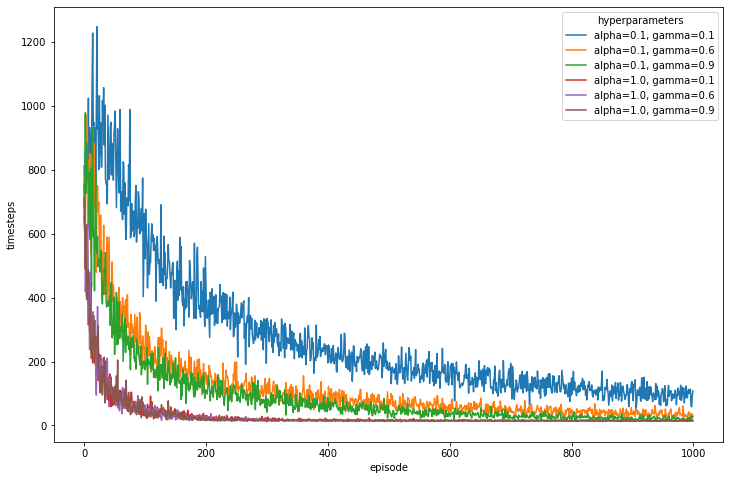

In [164]:
fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.lineplot('episode', 'timesteps', hue='hyperparameters', data=results)

## Analyzing different values of epsilon for better result

In [165]:
# best hyper-parameters so far
alpha = 1.0
gamma = 0.9

epsilons = [0.01, 0.10, 0.9]
n_runs = 10
n_episodes = 200

results = pd.DataFrame()
for epsilon in epsilons:
        
    print(f'epsilon: {epsilon}')
    agent = QAgent(env, alpha, gamma)

    timesteps, penalties = train_many_runs(agent,
                                           env,
                                           n_episodes,
                                           epsilon,
                                           n_runs)

    # collect timesteps and penalties for this pair of
    # hyper-parameters (alpha, gamma)
    results_ = pd.DataFrame()
    results_['timesteps'] = timesteps
    results_['penalties'] = penalties
    results_['epsilon'] = epsilon
    results = pd.concat([results, results_])

# index -> episode
results = results.reset_index().rename(columns={'index': 'episode'})

epsilon: 0.01


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 431.37it/s]


epsilon: 0.1


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 397.44it/s]


epsilon: 0.9


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:01<00:00, 102.69it/s]


# Implementing a grid search to discover the best hyperparameters (2)

In [166]:
results

,episode,timesteps,penalties,epsilon
0,0,489.5,82.9,0.01
1,1,590.8,96.4,0.01
2,2,540.1,67.9,0.01
3,3,470.5,64.9,0.01
4,4,379.6,55.2,0.01
...,...,...,...,...
595,195,223.4,64.2,0.90
596,196,205.8,60.8,0.90
597,197,253.2,72.3,0.90
598,198,173.3,50.0,0.90


In [167]:
X = results.iloc[:, :3].values
Y = results.iloc[:, 3].values.reshape(-1,1)

In [168]:
print(np.shape(X))
print(np.shape(Y))

(600, 3)
(600, 1)


In [169]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .2, random_state = 2022)

In [170]:
xgb_model = XGBRegressor(random_state = 2022)

In [171]:
# make a dictionary of hyperparameter values to search
search_space = {
    "n_estimators" : [100, 200, 300, 400, 500],
    "max_depth" : [3, 6, 9],
    "gamma" : [0.01, 0.1],
    "learning_rate" : [0.001, 0.01, 0.1, 1]
}

In [172]:
from sklearn.model_selection import GridSearchCV
# make a GridSearchCV object
GS = GridSearchCV(estimator = xgb_model, 
                  param_grid = search_space,
                  scoring = ["r2", "neg_root_mean_squared_error"], # sklearn.metrics.SCORES.keys()
                  refit = "r2",
                  cv = 5,
                  verbose = 4)

In [173]:
GS.fit(X_train, Y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-0.390) r2: (test=-0.083) total time=   0.0s
[CV 2/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-0.391) r2: (test=0.068) total time=   0.0s
[CV 3/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-0.397) r2: (test=-0.007) total time=   0.0s
[CV 4/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-0.392) r2: (test=0.078) total time=   0.0s
[CV 5/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-0.394) r2: (test=0.054) total time=   0.0s
[CV 1/5] END gamma=0.01, learning_rate=0.001, max_depth=3, n_estimators=200; neg_root_mean_squared_error: (test=-0.353) r2: (test=0.112) total time=   0.1s

[CV 4/5] END gamma=0.01, learning_rate=0.001, max_depth=9, n_estimators=100; neg_root_mean_squared_error: (test=-0.392) r2: (test=0.078) total time=   0.0s
[CV 5/5] END gamma=0.01, learning_rate=0.001, max_depth=9, n_estimators=100; neg_root_mean_squared_error: (test=-0.394) r2: (test=0.054) total time=   0.0s
[CV 1/5] END gamma=0.01, learning_rate=0.001, max_depth=9, n_estimators=200; neg_root_mean_squared_error: (test=-0.354) r2: (test=0.108) total time=   0.2s
[CV 2/5] END gamma=0.01, learning_rate=0.001, max_depth=9, n_estimators=200; neg_root_mean_squared_error: (test=-0.355) r2: (test=0.230) total time=   0.1s
[CV 3/5] END gamma=0.01, learning_rate=0.001, max_depth=9, n_estimators=200; neg_root_mean_squared_error: (test=-0.361) r2: (test=0.168) total time=   0.1s
[CV 4/5] END gamma=0.01, learning_rate=0.001, max_depth=9, n_estimators=200; neg_root_mean_squared_error: (test=-0.357) r2: (test=0.233) total time=   0.1s
[CV 5/5] END gamma=0.01, learning_rate=0.001, max_depth=9, n_est

[CV 2/5] END gamma=0.01, learning_rate=0.01, max_depth=6, n_estimators=200; neg_root_mean_squared_error: (test=-0.100) r2: (test=0.939) total time=   0.2s
[CV 3/5] END gamma=0.01, learning_rate=0.01, max_depth=6, n_estimators=200; neg_root_mean_squared_error: (test=-0.101) r2: (test=0.934) total time=   0.2s
[CV 4/5] END gamma=0.01, learning_rate=0.01, max_depth=6, n_estimators=200; neg_root_mean_squared_error: (test=-0.126) r2: (test=0.904) total time=   0.1s
[CV 5/5] END gamma=0.01, learning_rate=0.01, max_depth=6, n_estimators=200; neg_root_mean_squared_error: (test=-0.064) r2: (test=0.975) total time=   0.2s
[CV 1/5] END gamma=0.01, learning_rate=0.01, max_depth=6, n_estimators=300; neg_root_mean_squared_error: (test=-0.044) r2: (test=0.986) total time=   0.3s
[CV 2/5] END gamma=0.01, learning_rate=0.01, max_depth=6, n_estimators=300; neg_root_mean_squared_error: (test=-0.087) r2: (test=0.954) total time=   0.3s
[CV 3/5] END gamma=0.01, learning_rate=0.01, max_depth=6, n_estimators

[CV 5/5] END gamma=0.01, learning_rate=0.1, max_depth=3, n_estimators=200; neg_root_mean_squared_error: (test=-0.024) r2: (test=0.997) total time=   0.1s
[CV 1/5] END gamma=0.01, learning_rate=0.1, max_depth=3, n_estimators=300; neg_root_mean_squared_error: (test=-0.031) r2: (test=0.993) total time=   0.2s
[CV 2/5] END gamma=0.01, learning_rate=0.1, max_depth=3, n_estimators=300; neg_root_mean_squared_error: (test=-0.085) r2: (test=0.956) total time=   0.2s
[CV 3/5] END gamma=0.01, learning_rate=0.1, max_depth=3, n_estimators=300; neg_root_mean_squared_error: (test=-0.081) r2: (test=0.958) total time=   0.2s
[CV 4/5] END gamma=0.01, learning_rate=0.1, max_depth=3, n_estimators=300; neg_root_mean_squared_error: (test=-0.116) r2: (test=0.919) total time=   0.3s
[CV 5/5] END gamma=0.01, learning_rate=0.1, max_depth=3, n_estimators=300; neg_root_mean_squared_error: (test=-0.024) r2: (test=0.997) total time=   0.2s
[CV 1/5] END gamma=0.01, learning_rate=0.1, max_depth=3, n_estimators=400; n

[CV 4/5] END gamma=0.01, learning_rate=0.1, max_depth=9, n_estimators=300; neg_root_mean_squared_error: (test=-0.116) r2: (test=0.919) total time=   0.3s
[CV 5/5] END gamma=0.01, learning_rate=0.1, max_depth=9, n_estimators=300; neg_root_mean_squared_error: (test=-0.023) r2: (test=0.997) total time=   0.3s
[CV 1/5] END gamma=0.01, learning_rate=0.1, max_depth=9, n_estimators=400; neg_root_mean_squared_error: (test=-0.040) r2: (test=0.988) total time=   0.5s
[CV 2/5] END gamma=0.01, learning_rate=0.1, max_depth=9, n_estimators=400; neg_root_mean_squared_error: (test=-0.085) r2: (test=0.956) total time=   0.5s
[CV 3/5] END gamma=0.01, learning_rate=0.1, max_depth=9, n_estimators=400; neg_root_mean_squared_error: (test=-0.083) r2: (test=0.956) total time=   0.5s
[CV 4/5] END gamma=0.01, learning_rate=0.1, max_depth=9, n_estimators=400; neg_root_mean_squared_error: (test=-0.116) r2: (test=0.919) total time=   0.5s
[CV 5/5] END gamma=0.01, learning_rate=0.1, max_depth=9, n_estimators=400; n

[CV 3/5] END gamma=0.01, learning_rate=1, max_depth=6, n_estimators=400; neg_root_mean_squared_error: (test=-0.083) r2: (test=0.956) total time=   0.4s
[CV 4/5] END gamma=0.01, learning_rate=1, max_depth=6, n_estimators=400; neg_root_mean_squared_error: (test=-0.118) r2: (test=0.916) total time=   0.4s
[CV 5/5] END gamma=0.01, learning_rate=1, max_depth=6, n_estimators=400; neg_root_mean_squared_error: (test=-0.024) r2: (test=0.997) total time=   0.4s
[CV 1/5] END gamma=0.01, learning_rate=1, max_depth=6, n_estimators=500; neg_root_mean_squared_error: (test=-0.071) r2: (test=0.964) total time=   0.6s
[CV 2/5] END gamma=0.01, learning_rate=1, max_depth=6, n_estimators=500; neg_root_mean_squared_error: (test=-0.082) r2: (test=0.959) total time=   0.6s
[CV 3/5] END gamma=0.01, learning_rate=1, max_depth=6, n_estimators=500; neg_root_mean_squared_error: (test=-0.083) r2: (test=0.956) total time=   0.6s
[CV 4/5] END gamma=0.01, learning_rate=1, max_depth=6, n_estimators=500; neg_root_mean_s

[CV 2/5] END gamma=0.1, learning_rate=0.001, max_depth=3, n_estimators=500; neg_root_mean_squared_error: (test=-0.270) r2: (test=0.557) total time=   0.5s
[CV 3/5] END gamma=0.1, learning_rate=0.001, max_depth=3, n_estimators=500; neg_root_mean_squared_error: (test=-0.275) r2: (test=0.516) total time=   0.5s
[CV 4/5] END gamma=0.1, learning_rate=0.001, max_depth=3, n_estimators=500; neg_root_mean_squared_error: (test=-0.274) r2: (test=0.549) total time=   0.5s
[CV 5/5] END gamma=0.1, learning_rate=0.001, max_depth=3, n_estimators=500; neg_root_mean_squared_error: (test=-0.267) r2: (test=0.565) total time=   0.5s
[CV 1/5] END gamma=0.1, learning_rate=0.001, max_depth=6, n_estimators=100; neg_root_mean_squared_error: (test=-0.391) r2: (test=-0.085) total time=   0.0s
[CV 2/5] END gamma=0.1, learning_rate=0.001, max_depth=6, n_estimators=100; neg_root_mean_squared_error: (test=-0.391) r2: (test=0.069) total time=   0.0s
[CV 3/5] END gamma=0.1, learning_rate=0.001, max_depth=6, n_estimator

[CV 5/5] END gamma=0.1, learning_rate=0.001, max_depth=9, n_estimators=500; neg_root_mean_squared_error: (test=-0.267) r2: (test=0.568) total time=   0.5s
[CV 1/5] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-0.160) r2: (test=0.819) total time=   0.0s
[CV 2/5] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-0.176) r2: (test=0.812) total time=   0.0s
[CV 3/5] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-0.180) r2: (test=0.792) total time=   0.0s
[CV 4/5] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-0.188) r2: (test=0.788) total time=   0.0s
[CV 5/5] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100; neg_root_mean_squared_error: (test=-0.165) r2: (test=0.834) total time=   0.0s
[CV 1/5] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200; 

[CV 4/5] END gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=100; neg_root_mean_squared_error: (test=-0.188) r2: (test=0.788) total time=   0.0s
[CV 5/5] END gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=100; neg_root_mean_squared_error: (test=-0.164) r2: (test=0.836) total time=   0.0s
[CV 1/5] END gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=200; neg_root_mean_squared_error: (test=-0.072) r2: (test=0.963) total time=   0.2s
[CV 2/5] END gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=200; neg_root_mean_squared_error: (test=-0.102) r2: (test=0.937) total time=   0.2s
[CV 3/5] END gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=200; neg_root_mean_squared_error: (test=-0.105) r2: (test=0.930) total time=   0.2s
[CV 4/5] END gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=200; neg_root_mean_squared_error: (test=-0.130) r2: (test=0.898) total time=   0.1s
[CV 5/5] END gamma=0.1, learning_rate=0.01, max_depth=9, n_estimators=200; n

[CV 3/5] END gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=200; neg_root_mean_squared_error: (test=-0.087) r2: (test=0.951) total time=   0.2s
[CV 4/5] END gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=200; neg_root_mean_squared_error: (test=-0.123) r2: (test=0.909) total time=   0.2s
[CV 5/5] END gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=200; neg_root_mean_squared_error: (test=-0.034) r2: (test=0.993) total time=   0.2s
[CV 1/5] END gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=300; neg_root_mean_squared_error: (test=-0.045) r2: (test=0.986) total time=   0.3s
[CV 2/5] END gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=300; neg_root_mean_squared_error: (test=-0.087) r2: (test=0.954) total time=   0.3s
[CV 3/5] END gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=300; neg_root_mean_squared_error: (test=-0.087) r2: (test=0.951) total time=   0.3s
[CV 4/5] END gamma=0.1, learning_rate=0.1, max_depth=6, n_estimators=300; neg_root

[CV 2/5] END gamma=0.1, learning_rate=1, max_depth=3, n_estimators=300; neg_root_mean_squared_error: (test=-0.091) r2: (test=0.950) total time=   0.2s
[CV 3/5] END gamma=0.1, learning_rate=1, max_depth=3, n_estimators=300; neg_root_mean_squared_error: (test=-0.096) r2: (test=0.941) total time=   0.2s
[CV 4/5] END gamma=0.1, learning_rate=1, max_depth=3, n_estimators=300; neg_root_mean_squared_error: (test=-0.121) r2: (test=0.912) total time=   0.2s
[CV 5/5] END gamma=0.1, learning_rate=1, max_depth=3, n_estimators=300; neg_root_mean_squared_error: (test=-0.052) r2: (test=0.984) total time=   0.2s
[CV 1/5] END gamma=0.1, learning_rate=1, max_depth=3, n_estimators=400; neg_root_mean_squared_error: (test=-0.031) r2: (test=0.993) total time=   0.4s
[CV 2/5] END gamma=0.1, learning_rate=1, max_depth=3, n_estimators=400; neg_root_mean_squared_error: (test=-0.091) r2: (test=0.950) total time=   0.4s
[CV 3/5] END gamma=0.1, learning_rate=1, max_depth=3, n_estimators=400; neg_root_mean_squared_

[CV 2/5] END gamma=0.1, learning_rate=1, max_depth=9, n_estimators=400; neg_root_mean_squared_error: (test=-0.088) r2: (test=0.953) total time=   0.5s
[CV 3/5] END gamma=0.1, learning_rate=1, max_depth=9, n_estimators=400; neg_root_mean_squared_error: (test=-0.088) r2: (test=0.950) total time=   0.5s
[CV 4/5] END gamma=0.1, learning_rate=1, max_depth=9, n_estimators=400; neg_root_mean_squared_error: (test=-0.121) r2: (test=0.912) total time=   0.5s
[CV 5/5] END gamma=0.1, learning_rate=1, max_depth=9, n_estimators=400; neg_root_mean_squared_error: (test=-0.031) r2: (test=0.994) total time=   0.5s
[CV 1/5] END gamma=0.1, learning_rate=1, max_depth=9, n_estimators=500; neg_root_mean_squared_error: (test=-0.064) r2: (test=0.971) total time=   0.6s
[CV 2/5] END gamma=0.1, learning_rate=1, max_depth=9, n_estimators=500; neg_root_mean_squared_error: (test=-0.088) r2: (test=0.953) total time=   0.6s
[CV 3/5] END gamma=0.1, learning_rate=1, max_depth=9, n_estimators=500; neg_root_mean_squared_

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                              

In [174]:
print(GS.best_estimator_) # to get the complete details of the best model

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.01, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=2022,
             reg_alpha=0, reg_lambda=1, ...)


In [175]:
print(GS.best_params_) # to get only the best hyperparameter values

{'gamma': 0.01, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}


In [176]:
print(GS.best_score_) # score according to the metric we passed in refit

0.9646816028352385


In [177]:
df = pd.DataFrame(GS.cv_results_)
df = df.sort_values("rank_test_r2")
df.to_csv("cv_results-2.csv")

# Plot analysis (3)

C:\Users\Shahin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


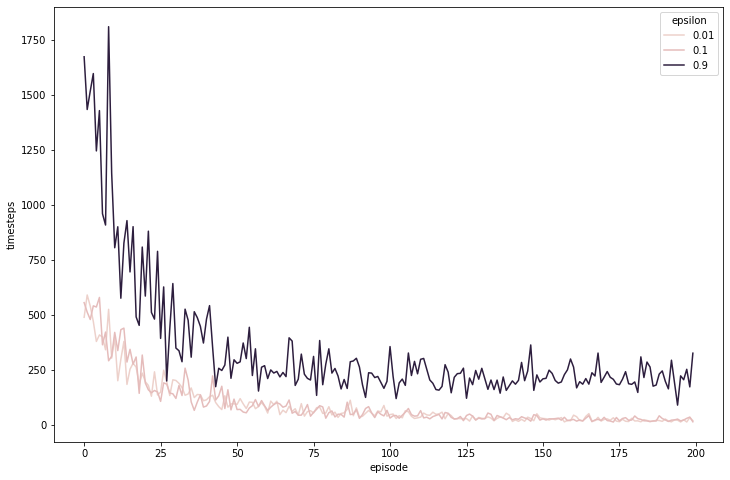

C:\Users\Shahin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='episode', ylabel='penalties'>

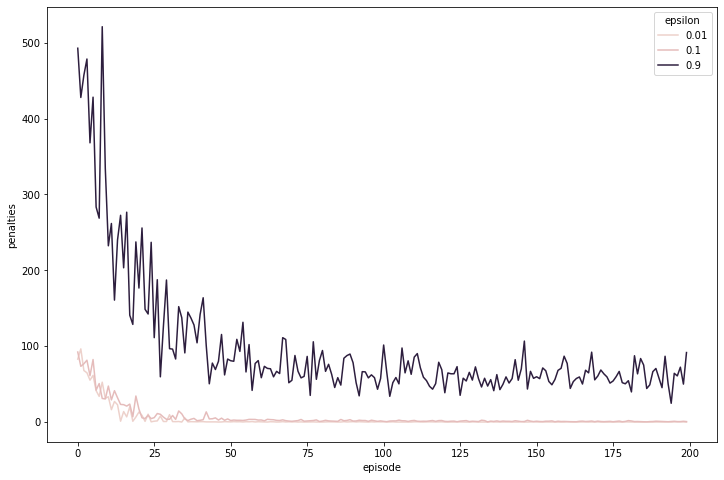

In [178]:
fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.lineplot('episode', 'timesteps', hue='epsilon', data=results)
plt.show()

fig = plt.gcf()
fig.set_size_inches(12, 8)
sns.lineplot('episode', 'penalties', hue='epsilon', data=results)